In [4]:
import numpy as np
import pandas as pd
from pyne import data, nucname
from pyne.material import Material
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
results_path = '/mnt/researchdrive/BOX_INTERNAL/opotowsky/'

In [3]:
df_idx = 88087

## Read in 1 File of Gamma Spectra

In [5]:
d1_dir = 'detector_response/d2_detective_hpge/'
d1numcol = 8192
d2_dir = 'detector_response/d2_detective_hpge/'
d2numcol = 8192
d3_dir = 'detector_response/d3_czt/'
d3numcol = 1024
d4_dir = 'detector_response/d4_nai/'
d4numcol = 1024
d5_dir = 'detector_response/d5_labr3/'
d5numcol = 1024
d6_dir = 'detector_response/d6_sri2/'
d6numcol = 1024

In [6]:
datidx = '1000'
d1_datgz = results_path + d1_dir + datidx + '.dat.gz'
d2_datgz = results_path + d2_dir + datidx + '.dat.gz'
d3_datgz = results_path + d3_dir + datidx + '.dat.gz'
d4_datgz = results_path + d4_dir + datidx + '.dat.gz'
d5_datgz = results_path + d5_dir + datidx + '.dat.gz'
d6_datgz = results_path + d6_dir + datidx + '.dat.gz'

In [11]:
def get_energy_bins(bindata):
    with open(bindata) as binfile:
        contents = binfile.readlines()
    binlist = []
    for ebin in contents[1].strip().split(' '):
        binlist.append(float(ebin))
    return binlist
#d1_energy_bins = get_energy_bins(results_path + d1_dir + 'energy_bins.dat')
#d2_energy_bins = get_energy_bins(results_path + d2_dir + 'energy_bins.dat')
#d3_energy_bins = get_energy_bins(results_path + d3_dir + 'energy_bins.dat')
d4_energy_bins = get_energy_bins(results_path + d4_dir + 'energy_bins.dat')
d5_energy_bins = get_energy_bins(results_path + d5_dir + 'energy_bins.dat')
d6_energy_bins = get_energy_bins(results_path + d6_dir + 'energy_bins.dat')

In [8]:
# reads in all 88 spectra in *.dat.gz into a df, and puts energy bins as columns
d1_df = pd.read_csv(d1_datgz, sep=' ', index_col=0, header=None, usecols=range(0, d1numcol+1), names=['DbIdx']+d1_energy_bins, compression='gzip')
d2_df = pd.read_csv(d2_datgz, sep=' ', index_col=0, header=None, usecols=range(0, d2numcol+1), names=['DbIdx']+d2_energy_bins, compression='gzip')
d3_df = pd.read_csv(d3_datgz, sep=' ', index_col=0, header=None, usecols=range(0, d3numcol+1), names=['DbIdx']+d3_energy_bins, compression='gzip')

In [12]:
d4_df = pd.read_csv(d4_datgz, sep=' ', index_col=0, header=None, usecols=range(0, d4numcol+1), names=['DbIdx']+d4_energy_bins, compression='gzip')
d5_df = pd.read_csv(d5_datgz, sep=' ', index_col=0, header=None, usecols=range(0, d5numcol+1), names=['DbIdx']+d5_energy_bins, compression='gzip')
d6_df = pd.read_csv(d6_datgz, sep=' ', index_col=0, header=None, usecols=range(0, d6numcol+1), names=['DbIdx']+d6_energy_bins, compression='gzip')

## Plot a Test Spectrum

In [15]:
def plot_spectrum(df_idx):
    fig, ax = plt.subplots()
    ax.plot(energy_bins, df.loc[df_idx], linewidth = 2)
    ax.set_title('Spectrum, Idx: ' + str(df_idx), fontsize=12)
    ax.set_xlim(0, 2500)
    ax.set_ylim(0, 3e5)
    plt.show()

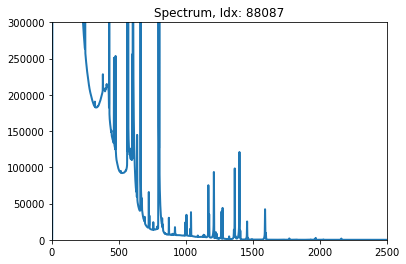

In [16]:
plot_spectrum(df_idx)

# Method 1: PyNE-based Energy Windows
## Pull in Gamma Energies Using PyNE

In [4]:
db = pd.read_pickle(results_path + 'nuc32_activities_scaled_1g_reindex.pkl')

In [6]:
nuc_list = ['ac227', 'am241', 'am243', 'ba133', 'cf249', 'cf252', 'cm243', 'cm244', 
            'cm245', 'cs134', 'cs137', 'eu152', 'eu154', 'ho166m', 'kr85', 'nb94', 
            'np236', 'np237', 'pa231', 'pm146', 'pu236', 'pu238', 'pu239', 'pu240', 
            'ra226', 'sb125', 'th228', 'th229', 'u232', 'u233', 'u234', 'u235']

In [7]:
def manual_gammas(nuclide):
    parent = nucname.id(nuclide)
    decay_c = data.decay_const(parent)
    energies = data.gamma_energy(parent)
    intensities = data.gamma_photon_intensity(parent)
    children = data.gamma_from_to_byparent(parent)
    decay_children = data.decay_data_children(parent)
    decay_branches = data.decay_photon_branch_ratio_byparent(parent)
    
    gammas_result = []
    for i, c in enumerate(children):
        for j, dc in enumerate(decay_children):
            # here is where we skip negative nuclides
            if c[0] > 0:
                if nucname.zzzaaa(c[0]) == nucname.zzzaaa(dc):
                    gammas_result.append((energies[i][0], decay_c*intensities[i][0]*decay_branches[j][0]))
    return gammas_result

In [8]:
gamma_dflist = []
for nuc in nuc_list:
    mat = Material()
    act_bq = db.loc[df_idx][nuc] * 3.7e10
    mat.from_activity({nuc : act_bq})
    gamlist = manual_gammas(nuc)
    gamma = pd.DataFrame(gamlist, columns = ['energy', 'rel_intensity'])
    # get gamma intensity in decay/s
    num_atoms = mat.mass * 6.02e23 / data.atomic_mass(nucname.id(nuc))
    gamma['total_intensity'] = num_atoms * gamma['rel_intensity']
    # get num of decays by multiplying by livetime (600 sec)
    gamma['test_counts'] = gamma['total_intensity'] * 600 # detectors measure for 600 seconds
    gamma['nucID'] = nuc
    gamma['half life (y)'] = data.half_life(nucname.id(nuc)) / 60 / 60 / 24 / 365.25
    gamma_dflist.append(gamma)
all_gammas = pd.concat(gamma_dflist).reset_index(drop=True)

In [9]:
nuc_plot = sorted(all_gammas.nucID.unique())

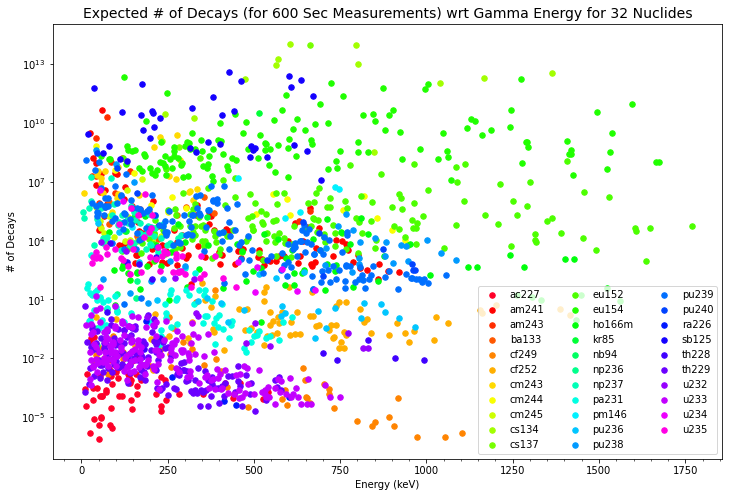

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
num_colors = len(nuc_list)
cm = plt.get_cmap('gist_rainbow')
for i, nuc in enumerate(nuc_list):
    ix = np.where(all_gammas['nucID'] == nuc)
    ax.scatter(all_gammas['energy'].iloc[ix], all_gammas['test_counts'].iloc[ix], 
               color = cm(1.*i/num_colors), label = nuc, s = 30)
ax.minorticks_on()
plt.title('Expected # of Decays (for 600 Sec Measurements) wrt Gamma Energy for 32 Nuclides', fontsize=14)
plt.yscale('log')
ax.set_xlabel('Energy (keV)')
ax.set_ylabel('# of Decays')
ax.legend(loc='best', ncol=3)
plt.show()

## Choose Energy Bin Windows

In [17]:
min_decays = 5e9
exp_lines = all_gammas.loc[all_gammas['test_counts'] > min_decays].sort_values('energy')
en_list = exp_lines['energy'].tolist()
len(en_list)

64

In [18]:
exp_lines[['nucID', 'half life (y)']].drop_duplicates()

,nucID,half life (y)
4264,sb125,2.75856
79,am241,432.60000
195,am243,7364.00000
3647,eu154,8.60100
3457,cs134,2.06520
3853,kr85,10.73900
3470,cs137,30.08000


In [11]:
min_decays = 5e8
exp_lines = all_gammas.loc[all_gammas['test_counts'] > min_decays].sort_values('energy')
exp_lines[['nucID', 'half life (y)']].drop_duplicates()

,nucID,half life (y)
4263,sb125,2.75856
68,am241,432.60000
3422,cm244,18.10000
190,am243,7364.00000
3647,eu154,8.60100
3397,cm243,29.10000
3456,cs134,2.06520
3469,cs137,30.08000
3853,kr85,10.73900


## Save Energy Windows as List

In [40]:
#import pickle
#en_list_pkl = 'idx88087_energy_list_31.pkl'
#with open(results_path + 'detector_response/' + en_list_pkl, 'wb') as filehandle:
#    pickle.dump(en_list, filehandle)

## Plot Spectrum with Energy Windows

In [16]:
en_delta = 2 #energy window in keV

In [27]:
def plot_spectrum_withlines(df_idx):
    fig, ax = plt.subplots(4, figsize=(18, 18))
    fig.suptitle('Spectrum, Idx: ' + str(df_idx), fontsize=18)
    for a in ax:
        a.plot(energy_bins, df.loc[df_idx], linewidth = 3)
        a.minorticks_on()
        for en in en_list:
            a.axvline(x=en, color='r', linewidth=0.5)
            a.axvspan(en - en_delta, en + en_delta, color='grey', alpha=0.3)
    ax[0].set_title('Low Energy', fontsize=12)
    ax[0].set_xlim(0, 450)
    ax[0].set_ylim(0, 1e6)
    ax[1].set_title('Med Energy', fontsize=12)
    ax[1].set_xlim(450, 900)
    ax[1].set_ylim(0, 2e5)
    ax[2].set_title('High Energy', fontsize=12)
    ax[2].set_xlim(900, 1700)
    ax[2].set_ylim(0, 5e4)
    ax[3].set_title('XHigh Energy', fontsize=12)
    ax[3].set_xlim(1700, 2500)
    ax[3].set_ylim(0, 1e3)
    plt.show()

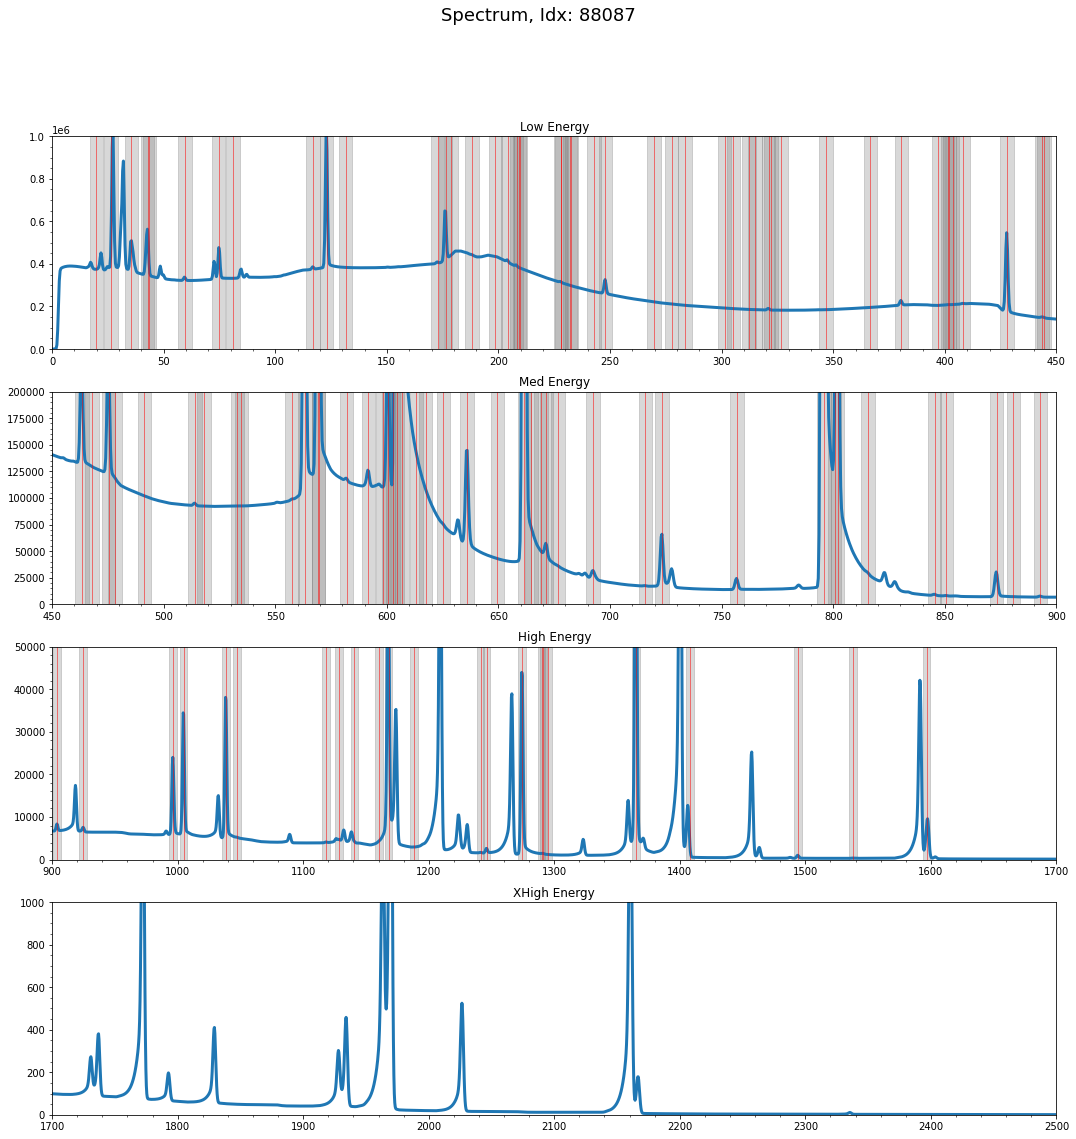

In [28]:
df_idx = 88087
plot_spectrum_withlines(df_idx)

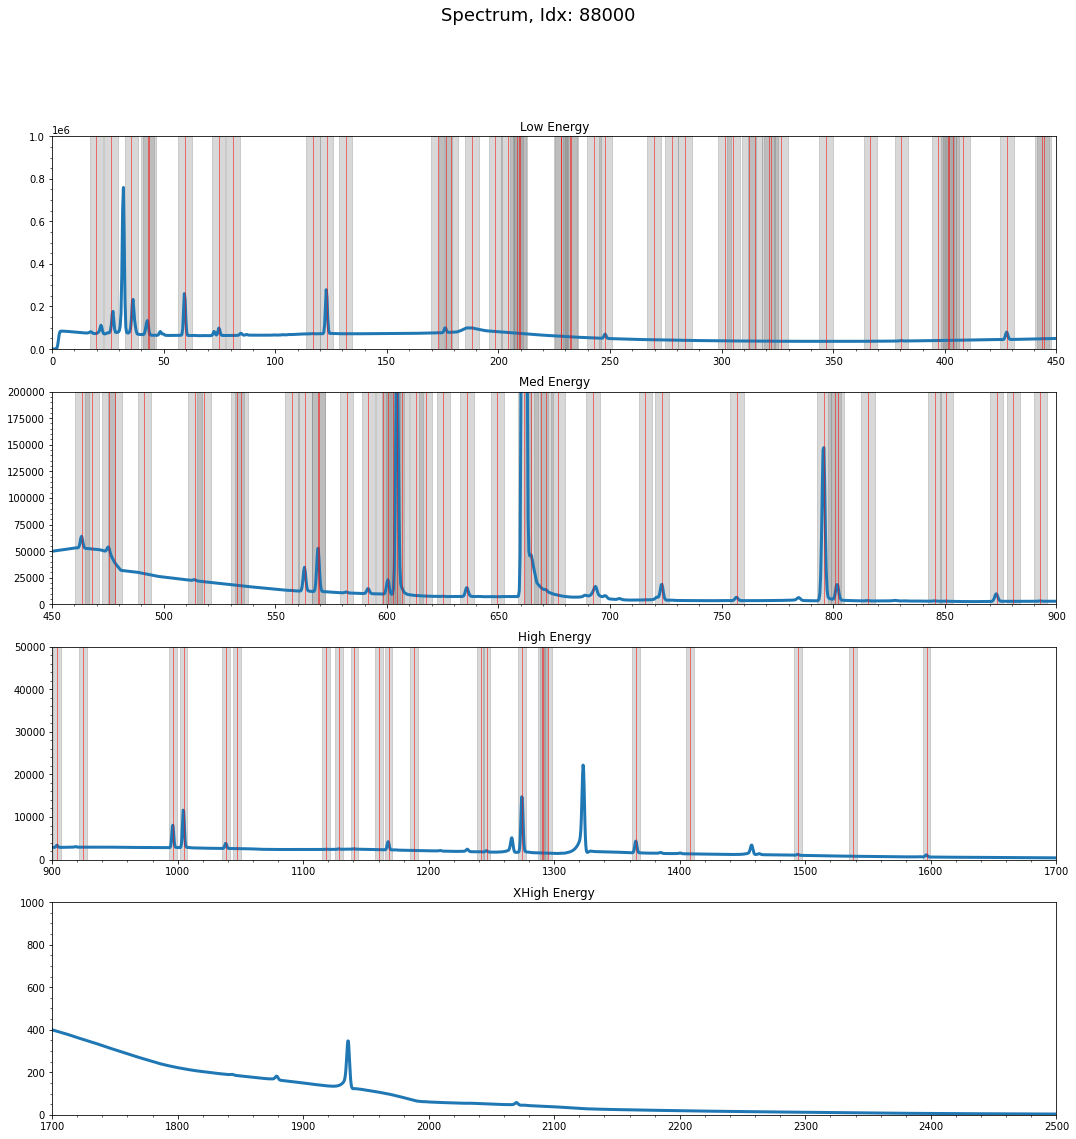

In [29]:
df_idx = 88000
plot_spectrum_withlines(df_idx)

# Method 2: Peak Finding for Energy Windows
## Attempt Auto Peak Find 

In [13]:
import scipy.signal
#from vector import plot_peaks

In [14]:
#idxs1, _ = scipy.signal.find_peaks(d1_df.loc[df_idx])
#idxs2, _ = scipy.signal.find_peaks(d2_df.loc[df_idx])
#idxs3, _ = scipy.signal.find_peaks(d3_df.loc[df_idx])
idxs4, _ = scipy.signal.find_peaks(d4_df.loc[df_idx])
idxs5, _ = scipy.signal.find_peaks(d5_df.loc[df_idx])
idxs6, _ = scipy.signal.find_peaks(d6_df.loc[df_idx])

In [15]:
print(len(idxs4), len(idxs5), len(idxs6))

9 19 18


In [16]:
#en_list1 = [en for i, en in enumerate(d1_energy_bins) if i in idxs1]
#en_list2 = [en for i, en in enumerate(d2_energy_bins) if i in idxs2]
#en_list3 = [en for i, en in enumerate(d3_energy_bins) if i in idxs3]
en_list4 = [en for i, en in enumerate(d4_energy_bins) if i in idxs4]
en_list5 = [en for i, en in enumerate(d5_energy_bins) if i in idxs5]
en_list6 = [en for i, en in enumerate(d6_energy_bins) if i in idxs6]
#print(en_list)

In [38]:
#import pickle
#en_list_pkl4 = 'idx88087_energy_list_d4auto.pkl'
#en_list_pkl5 = 'idx88087_energy_list_d5auto.pkl'
#en_list_pkl6 = 'idx88087_energy_list_d6auto.pkl'
#with open(results_path + 'detector_response/' + en_list_pkl4, 'wb') as filehandle:
#    pickle.dump(en_list4, filehandle)
#with open(results_path + 'detector_response/' + en_list_pkl5, 'wb') as filehandle:
#    pickle.dump(en_list5, filehandle)
#with open(results_path + 'detector_response/' + en_list_pkl6, 'wb') as filehandle:
#    pickle.dump(en_list6, filehandle)

In [31]:
def plot_spectrum_autolines(df_idx):
    fig, ax = plt.subplots(4, figsize=(18, 18))
    fig.suptitle('Spectrum, Idx: ' + str(df_idx), fontsize=18)
    for a in ax:
        a.plot(d6_energy_bins, d6_df.loc[df_idx], linewidth = 3)
        a.minorticks_on()
        for en in en_list6:
            a.axvline(x=en, color='r', linewidth=0.5)
            a.axvspan(en - en_delta, en + en_delta, color='grey', alpha=0.3)
    ax[0].set_title('Low Energy', fontsize=12)
    ax[0].set_xlim(0, 450)
    #ax[0].set_ylim(0, 4e6)
    ax[1].set_title('Med Energy', fontsize=12)
    ax[1].set_xlim(450, 900)
    ax[1].set_ylim(0, 8e5)
    ax[2].set_title('High Energy', fontsize=12)
    ax[2].set_xlim(900, 1700)
    ax[2].set_ylim(0, 2000)
    ax[3].set_title('More High Energy', fontsize=12)
    ax[3].set_xlim(1700, 2500)
    ax[3].set_ylim(0, 10)
    plt.show()

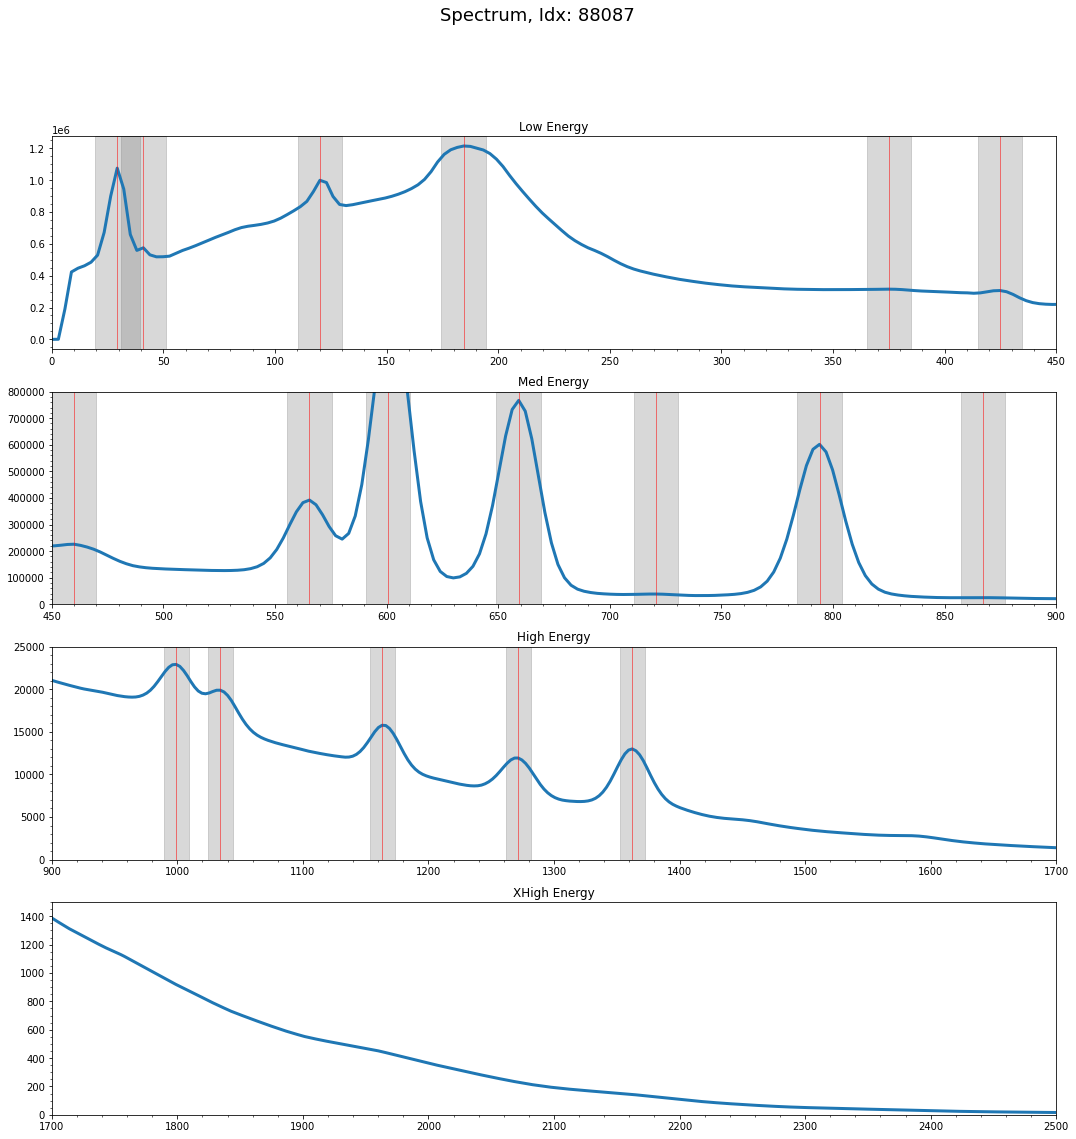

In [25]:
df_idx = 88087
en_delta = 10 # d6 en_delta
plot_spectrum_autolines(df_idx)

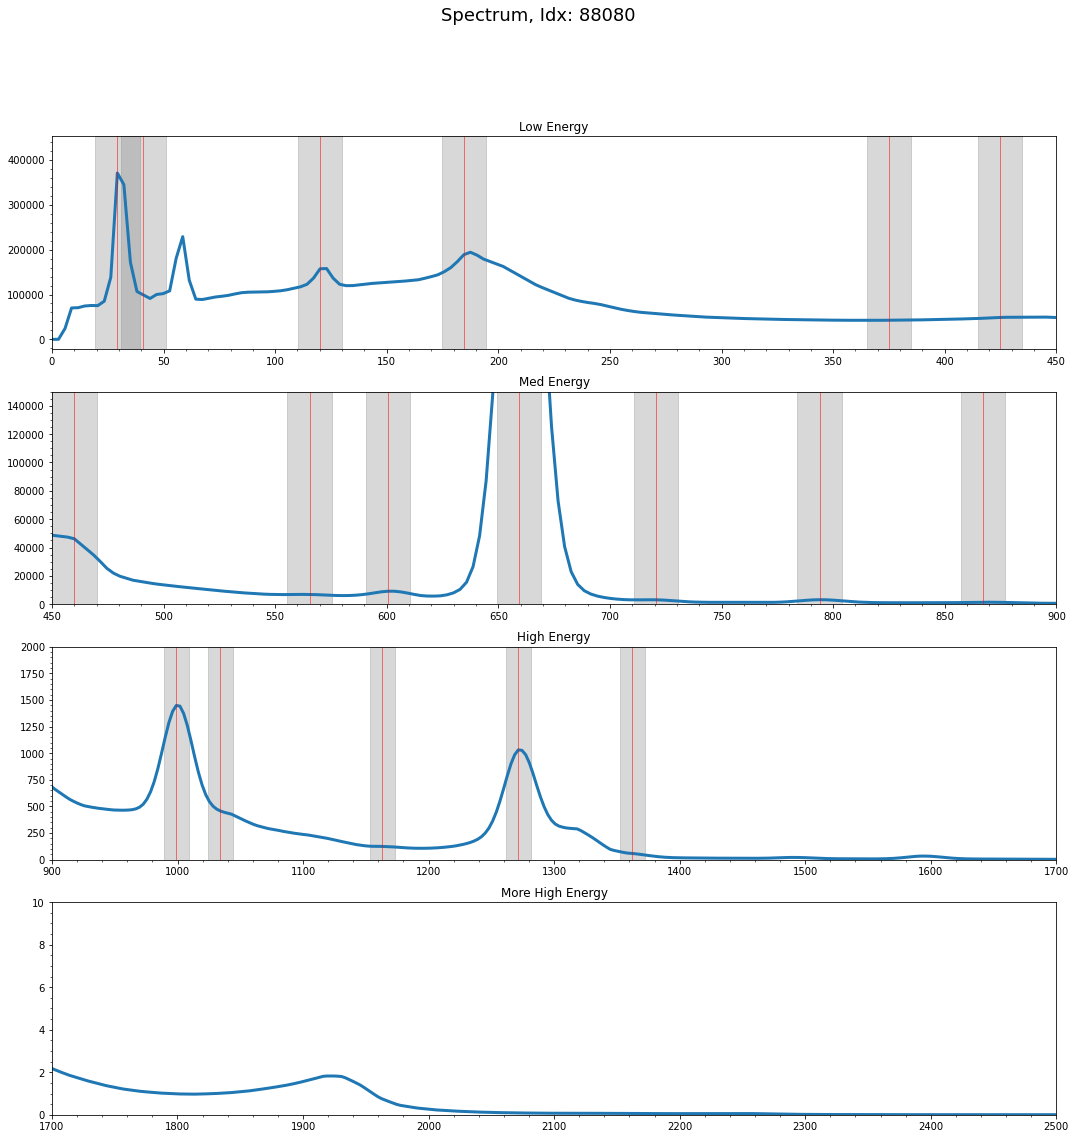

In [32]:
df_idx = 88080
plot_spectrum_autolines(df_idx)